# Overfitting'i Azaltmak için L1 ve L2 Regularization'ı

L1 ve L2 regulariation, overfitting etkilerini azaltabilen iki yaygın regularization tekniğidir. Bu algoritmaların her ikisi de ya bir objective fuction ya da bir backpropagation algoritmasının parçası olarak çalışabilir. Her iki durumda da regularization algoritması, ek bir hedef eklenerek eğitim algoritmasına eklenmektedir.</br>

Bu algoritmaların her ikisi de sinir ağı eğitimine bir ağırlık cezası ekleyerek çalışır. Bu ceza, sinir ağında ağırlıkları küçük değerlerde tutmayı sağlar. Hem L1 hem de L2 bu cezayı farklı şekilde hesaplar. Geri yayılım Backpropagation gibi gradient-descent-based  algoritmalar için, bu ceza hesaplaması hesaplanan gradient'lere eklenebilir. Simulated Annealing gibi objective function based eğitim için ceza, hedef puanla negatif olarak birleştirilmektedir. </br>

Hem L1 hem de L2, bir ağırlığın boyutunu cezalandırma biçiminde farklı şekilde çalışır. L2, ağırlıkları Gauss dağılımına benzer bir modele zorlarken; L1, ağırlıkları  Laplace dağılımına benzer bir modele zorlar.</br>

<img src='l1l2dist.png'/>
<center>(Kaynak : Jeff Heaton, Applications of Deep Neural Networks)</center>

In [1]:
import pandas as pd
from scipy.stats import zscore
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tensorflow.keras import regularizers

df = pd.read_csv('https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv', 
                na_values =[ 'NA', '?'])

df = pd.concat([df, pd.get_dummies(df['job'], prefix='job')], axis=1)
df.drop('job', axis=1, inplace=True)

df = pd.concat([df, pd.get_dummies(df['area'], prefix='area')], axis=1)
df.drop('area', axis=1, inplace=True)

median = df['income'].median()
df['income'] =  df['income'].fillna(median)

df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['age'] = zscore(df['age'])
df['subscriptions'] = zscore(df['subscriptions'])

x_columns = df.columns.drop('product').drop('id')
X = df[x_columns].values

dummies = pd.get_dummies(df['product'])
products = dummies.columns
y = dummies.values

In [2]:
model = Sequential()
model.add(Dense(50, input_dim=X.shape[1] ,activation='relu', 
                activity_regularizer=regularizers.l1(1e-4)))
model.add(Dense(25, activation='relu', activity_regularizer=regularizers.l1(1e-4)))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

kf = StratifiedKFold(5, shuffle=True, random_state=42)

real_y = list()
pred_y = list()

fold = 0
for train, test in kf.split(X, df['product']):
    fold += 1
    print('fold = ', fold)
    
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]
    model.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=0,
         epochs=10)
    
    predicted = model.predict(X_test)
    real_y.append(y_test)
    
    predicted = np.argmax(predicted, axis=1)
    pred_y.append(predicted)
    
    y_comp = np.argmax(y_test, axis=1)
    score = accuracy_score(y_comp, predicted)
    print(f'{fold}. cFold Score: {score}')

real_y = np.concatenate(real_y)
pred_y = np.concatenate(pred_y)

real_y_comp = np.argmax(real_y, axis=1)


final_score = accuracy_score(real_y_comp, pred_y)
print('Final_score = ', final_score)

fold =  1
1. cFold Score: 0.66
fold =  2
2. cFold Score: 0.7175
fold =  3
3. cFold Score: 0.7625
fold =  4
4. cFold Score: 0.785
fold =  5
5. cFold Score: 0.76
Final_score =  0.737


# Overfitting'i Azaltmak için Keras ile Drop Out

Hinton, Srivastava, Krizhevsky, Sutskever ve Salakhutdinov (2012) ile dropout regularization algoritmasını tanıtmışlardır. Dropout, L1 ve L2'den farklı bir şekilde çalışsa da, aynı hedefi gerçekleştirmektedir. Bununla birlikte, algoritma, nöronları ve bağlantıları en azından geçici olarak kaldırarak bu görevi görevi yerine getirir. L1 ve L2'nin aksine, ağırlık cezası eklenmez. </br>

Dropout, sinir ağının gizli nöronlarının eğitimin bir bölümünde kullanılamamasını sağlayarak olarak çalışır. Sinir ağının bir kısmının düşmesi, kalan kısmın, düşürülmüş nöronlar olmasa bile bir score elde etmek için eğitilmesine neden olur. Bu, nöronlar arasındaki eş adaptasyonu azaltır ve bu da daha az overfitting ile sonuçlanır.</br>

Çoğu neural network framework, dropout'ı ayrı bir katman olarak uygular. Dropout katmanları, regular, densely şekilde bağlı bir sinir ağı katmanı olarak işlev görür. Tek fark, dropout katmanlarının eğitim sırasında periyodik olarak bazı nöronlarını düşürmesidir. Bırakma katmanları normal ileri beslemeli sinir ağlarında kullanılabilir.</br>

Uygulama, bazı nöronlarını ortadan kaldırabilen yoğun bir katman olarak bir dropout katmanı uygular. Dropout katmanı hakkındaki popüler inanışın aksine, program atılan bu nöronları kalıcı olarak ortadan kaldırmaz. Eğitim süreci sırasında bir bırakma katmanı nöronlarından hiçbirini kaybetmez ve eğitimden sonra hala tam olarak aynı sayıda nörona sahip olacaktır. Bu şekilde, program nöronları düşürmek yerine sadece geçici olarak maskeler. </br>

<img src='dropout.png'/>
<center>(Kaynak : Jeff Heaton, Applications of Deep Neural Networks)</center>

Şekilde atılan nöronlar ve bağlantıları kesikli çizgilerle gösterilmiştir. Giriş katmanı iki giriş nöronuna ve bir bias nöronuna sahiptir. İkinci katman, üç nöron ve bir bias neuron içeren yoğun bir katmandır. Üçüncü katman, nöronların % 50'sini düşürmesine rağmen altı normal nöron içeren bir dropout katmanıdır. Program bu nöronları düşürürken, onları ne hesaplar ne de eğitir. Bununla birlikte, nihai sinir ağı çıktı için tüm bu nöronları kullanacaktır. Yalnızca geçici olarak nöronlar atılır.</br>

İlerleyen eğitim yinelemeleri sırasında, program dropout katmanından farklı nöron setleri seçer. Bias nöronu asla düşürülmez. Sadece bir dropout katmanındaki normal nöronlar adaydır. </br>

Eğitim algoritmasının uygulanması, nöronların atılma sürecini etkiler. Dropout kümesi, training iteration veya batch başına sık sık bir kez değişir.</br>

Dropout'ın neden overfitting'i azaltabileceği yaygın bir sorudur. Cevap, bırakmanın iki nöron arasında gelişen bir bağımlılık olasılığını azaltabileceğidir.Bağımlılık geliştiren iki nöron, biri devre dışı bırakıldığında etkili bir şekilde çalışamayacaktır. Sonuç olarak, sinir ağı artık her nöronun varlığına güvenemez ve ona göre eğitilir. Bu özellik, kendisine sunulan bilgileri ezberleme yeteneğini azaltır.</br>

Dropout ayrıca sinir ağını bir bootstrapping sürecine zorlayarak overfitting'i azaltır. Bootstrapping çok yaygın bir ensemble tekniğidir. Temel olarak, birleştirme, tek tek modellerle elde edilenlerden daha iyi bir sonuç elde etmek için birden çok modeli birleştiren bir makine öğrenimi tekniğidir. </br>

Bootstrapping, en basit ensemble tekniklerinden biridir. Bootstrapping kullanan programcı, tamamen aynı görevi yerine getirmek için bir dizi sinir ağını eğitir. Bununla birlikte, bu sinir ağlarının her biri, bazı eğitim teknikleri ve sinir ağı ağırlıklarının başlatılmasında kullanılan rastgele sayılar nedeniyle farklı performans gösterecektir. Ağırlıklardaki fark, performans farklılığına neden olur. Bu sinir ağları topluluğunun çıktısı, birlikte ele alınan üyelerin ortalama çıktısı haline gelir. Bu süreç, farklı şekilde eğitilmiş sinir ağlarının fikir birliği yoluyla overfitting'i azaltır.</br>

Dropout, bir şekilde bootstrapğing gibi çalışır. Farklı nöron kümelerinin bir topluluktaki bireysel bir üye olarak atılmasından kaynaklanan her bir sinir ağını düşünebilirsiniz. Eğitim ilerledikçe, program bu şekilde daha fazla sinir ağı oluşturur. Ancak, dropout, bootstrapping ile aynı miktarda işlem gerektirmez. Oluşturulan yeni sinir ağları geçicidir; sadece bir eğitim tekrarı için var olurlar. Nihai sonuç, aynı zamanda, birlikte ortalaması alınacak bir sinir ağları topluluğu yerine tek bir sinir ağıdır.</br>



In [4]:
import pandas as pd
from scipy.stats import zscore
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tensorflow.keras import regularizers

df = pd.read_csv('https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv', 
                na_values =[ 'NA', '?'])

df = pd.concat([df, pd.get_dummies(df['job'], prefix='job')], axis=1)
df.drop('job', axis=1, inplace=True)

df = pd.concat([df, pd.get_dummies(df['area'], prefix='area')], axis=1)
df.drop('area', axis=1, inplace=True)

median = df['income'].median()
df['income'] =  df['income'].fillna(median)

df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['age'] = zscore(df['age'])
df['subscriptions'] = zscore(df['subscriptions'])

x_columns = df.columns.drop('product').drop('id')
X = df[x_columns].values

dummies = pd.get_dummies(df['product'])
products = dummies.columns
y = dummies.values

In [5]:
model = Sequential()
model.add(Dense(50, input_dim=X.shape[1] ,activation='relu', 
                activity_regularizer=regularizers.l1(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(25, activation='relu', activity_regularizer=regularizers.l1(1e-4)))
# Genellikle son hidden layer'dan sonra dropout katmanı eklenmez
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

kf = StratifiedKFold(5, shuffle=True, random_state=42)

real_y = list()
pred_y = list()

fold = 0
for train, test in kf.split(X, df['product']):
    fold += 1
    print('fold = ', fold)
    
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]
    model.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=0,
         epochs=10)
    
    predicted = model.predict(X_test)
    real_y.append(y_test)
    
    predicted = np.argmax(predicted, axis=1)
    pred_y.append(predicted)
    
    y_comp = np.argmax(y_test, axis=1)
    score = accuracy_score(y_comp, predicted)
    print(f'{fold}. cFold Score: {score}')

real_y = np.concatenate(real_y)
pred_y = np.concatenate(pred_y)


final_score = accuracy_score(real_y_comp, pred_y)
print('Final_score = ', final_score)

fold =  1
1. cFold Score: 0.6525
fold =  2
2. cFold Score: 0.6875
fold =  3
3. cFold Score: 0.71
fold =  4
4. cFold Score: 0.745
fold =  5
5. cFold Score: 0.6925
Final_score =  0.6975


# Regularization Tekniklerinin Kıyaslanması

Şimdiye kadar birçok hiperparametre anlatılmış oldu. Bu değerlerin her birinde ince ayar yapmak, sinir ağları tarafından elde edilen puan üzerinde bir etkiye sahip olabilir. Bu parametrelerden bazıları şunlardır

<li>Sinir ağındaki katman sayısı</li>
<li>Her katmanda kaç nöron olacağı</li>
<li>Her katmanda hangi etkinleştirme işlevlerinin kullanılacağı</li>
<li>Her katmanda dropout yüzdesi</li>
<li>Her katmandaki L1 ve L2 değerleri</li>

Bu hiperparametrelerin her birini denemek için, her bir hiperparametre için birden fazla ayara sahip sinir ağlarını çalıştırmak gereklidir. Bununla birlikte, sinir ağlarının birden çok kez eğitildiğinde genellikle biraz farklı sonuçlar verir. Bunun nedeni, sinir ağlarının rastgele ağırlıklarla başlamasıdır. Bu nedenle, bir hiperparametre kümesinin aslında diğerinden daha iyi olmasını sağlamak için bir sinir ağı zamanını uydurmak ve değerlendirmek gerekir. ShuffleSplit, iki hiperparametre setini kıyaslamanın (karşılaştırmanın) etkili yollarından biridir.</br>

ShuffleSplit, cross validation'a benzer. Her ikisi de doğrulama ve eğitim setleri sağlayan bir dizi döngü/ kümeden geçer. Bununla birlikte, ShuffleSplit'in sınırsız sayıda döngüsü olabilir. ShuffleSplit her döngüde değiştirme ile yeni eğitim ve doğrulama seti seçer. Her döngünün değiştirme ile seçilmesi, çapraz doğrulamadan farklı olarak, döngüler arasında sıklıkla tekrarlanan satırların seçileceği anlamına gelir. Bootstrapping yeterli döngü için çalıştırılırsa, yinelenen döngüler olacaktır.</br>

Aşağıdaki örnekte hiperparametre karşılaştırması için ShuffleSplit kullanılacaktır. Belirli sayıda bölünme için bir sinir ağını eğitilecektir (SPLITS sabiti ile gösterilir). Bu örnekler için 50 kullanılmıştır. 50'nin sonundaki ortalama puan karşılaştırılacaktır. Döngülerin sonunda ortalama puan bir şekilde birleşmiş olacaktır. Bu bitiş puanı, tek bir çapraz doğrulamaya göre çok daha iyi bir karşılaştırma temeli olacaktır.Ayrıca, olası bir optimum değer hakkında bir fikir vermek için ortalama dönem sayısı izlenecektir.  </br>

Kıyaslama yapıldığı için, her döngü için harcanan süre gösterilecektir. Aşağıdaki fonksiyon, zaman aralığını formatlamak amacı ile yazılmıştır.

In [2]:
def time_string(gecen_zaman):
    saat = int(gecen_zaman / (60 *60))
    dakika = int((gecen_zaman % (60 * 60)) / 60)
    saniye = gecen_zaman / 60
    return '{}:{:>02}:{:>05.2f}'.format(saat, dakika, saniye)

# Regression için ShuffleSplit

Regresyon ShuffleSplit'de, bölmeleri gerçekleştirmek için ShuffleSplit nesnesini kullanır. Bu, cross validation için KFold'a benzer.

In [1]:
import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time
import numpy as np
import statistics as stat

df = pd.read_csv('https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv', 
                na_values =[ 'NA', '?'])

df = pd.concat([df, pd.get_dummies(df['job'], prefix='job')], axis=1)
df.drop('job', axis=1, inplace=True)

df = pd.concat([df, pd.get_dummies(df['area'], prefix='area')], axis=1)
df.drop('area', axis=1, inplace=True)

df = pd.concat([df, pd.get_dummies(df['product'], prefix='product')], axis=1)
df.drop('product', axis=1, inplace=True)

median = df['income'].median()
df['income'] =  df['income'].fillna(median)

df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['subscriptions'] = zscore(df['subscriptions'])

x_columns = df.columns.drop('age').drop('id')
X = df[x_columns].values
y = df['age'].values

#-----------for shufflesplit------------------------------

SPLITS = 50

boot = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=42)

mean_benchmark = []
epochs_needed = []
num = 0

for train, test in boot.split(X):
    start_time = time.time()
    num += 1
    
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mean_squared_error', optimizer='adam')                                      
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto',
                           restore_best_weights=True)
    
    model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[monitor], verbose=0,
             epochs=100)
    
    epochs = monitor.stopped_epoch
    epochs_needed.append(epochs)
    
    predicted = model.predict(X_test)
    
    score = np.sqrt(mean_squared_error(y_test, predicted.flatten()))
    mean_benchmark.append(score)
    print(mean_benchmark)
    
    m1 = stat.mean(mean_benchmark)
    m2 = stat.mean(epochs_needed)
    mdev = np.std(mean_benchmark)
    
    time_took = time.time() - start_time
    
    print(f'{num}: score={score:.6f}, mean_score={m1:.6f}, stdev={mdev:.6f}, epochs={epochs}, mean_epochs={int(m2)}, time = {time_string(time_took)}')

Epoch 1/100
57/57 [==============================] - 1s 17ms/step - loss: 1732.1549 - val_loss: 1365.8824
Epoch 2/100
57/57 [==============================] - 1s 14ms/step - loss: 945.5132 - val_loss: 506.1621
Epoch 3/100
57/57 [==============================] - 1s 15ms/step - loss: 339.6662 - val_loss: 261.0542
Epoch 4/100
57/57 [==============================] - 0s 8ms/step - loss: 247.8031 - val_loss: 217.3592
Epoch 5/100
57/57 [==============================] - 1s 19ms/step - loss: 202.3597 - val_loss: 179.8428
Epoch 6/100
57/57 [==============================] - 1s 17ms/step - loss: 163.5751 - val_loss: 144.8181
Epoch 7/100
57/57 [==============================] - 1s 12ms/step - loss: 131.8227 - val_loss: 116.9398
Epoch 8/100
57/57 [==============================] - 1s 10ms/step - loss: 106.4499 - val_loss: 94.4582
Epoch 9/100
57/57 [==============================] - 1s 17ms/step - loss: 87.2589 - val_loss: 79.2531
Epoch 10/100
57/57 [==============================] - 1s 11ms/step

NameError: name 'time_string' is not defined

# Classification için ShuffleSplit

Classification için, StratifiedShuffleSplit nesnesini kullanır. Bu, çapraz doğrulama için StratifiedKFold'a benzer.

In [6]:
import pandas as pd
from scipy.stats import zscore
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import log_loss
from tensorflow.keras.callbacks import EarlyStopping
import time
import statistics as stat

df = pd.read_csv('https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv', 
                na_values =[ 'NA', '?'])

df = pd.concat([df, pd.get_dummies(df['job'], prefix='job')], axis=1)
df.drop('job', axis=1, inplace=True)

df = pd.concat([df, pd.get_dummies(df['area'], prefix='area')], axis=1)
df.drop('area', axis=1, inplace=True)

median = df['income'].median()
df['income'] =  df['income'].fillna(median)

df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['age'] = zscore(df['age'])
df['subscriptions'] = zscore(df['subscriptions'])

x_columns = df.columns.drop('product').drop('id')
X = df[x_columns].values

dummies = pd.get_dummies(df['product'])
products = dummies.columns
y = dummies.values


SPLITS = 50

boot = StratifiedShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=42)

mean_benchmark = []
epochs_needed = []
num = 0

for train, test in boot.split(X, df['product']):
    start_time = time.time()
    num += 1
    
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]
    model = Sequential()
    model.add(Dense(50, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=25, verbose=0, mode='auto',
                           restore_best_weights=True)
    
    model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[monitor], verbose=0,
             epochs=100)
    
    
    epochs = monitor.stopped_epoch
    epochs_needed.append(epochs)
    
    predicted = model.predict(X_test)
    
    y_compare = np.argmax(y_test, axis=1)
    score = log_loss(y_compare, predicted)
    mean_benchmark.append(score)
    print(mean_benchmark)
    
    m1 = stat.mean(mean_benchmark)
    m2 = stat.mean(epochs_needed)
    mdev = np.std(mean_benchmark)
    
    time_took = time.time() - start_time
    
    print(f'{num}: score={score:.6f}, mean_score={m1:.6f}, stdev={mdev:.6f}, epochs={epochs}, mean_epochs={int(m2)}, time = {time_string(time_took)}')

[0.6503752630599774]
1: score=0.650375, mean_score=0.650375, stdev=0.000000, epochs=92, mean_epochs=92, time = 0:00:00.39
[0.6503752630599774, 0.6660320709738881]
2: score=0.666032, mean_score=0.658204, stdev=0.007828, epochs=59, mean_epochs=75, time = 0:00:00.23
[0.6503752630599774, 0.6660320709738881, 0.659167352290824]
3: score=0.659167, mean_score=0.658525, stdev=0.006408, epochs=65, mean_epochs=72, time = 0:00:00.23
[0.6503752630599774, 0.6660320709738881, 0.659167352290824, 0.6404955003285431]
4: score=0.640496, mean_score=0.654018, stdev=0.009578, epochs=99, mean_epochs=78, time = 0:00:00.34
[0.6503752630599774, 0.6660320709738881, 0.659167352290824, 0.6404955003285431, 0.670703144017607]
5: score=0.670703, mean_score=0.657355, stdev=0.010860, epochs=84, mean_epochs=79, time = 0:00:00.34
[0.6503752630599774, 0.6660320709738881, 0.659167352290824, 0.6404955003285431, 0.670703144017607, 0.7032507740100846]
6: score=0.703251, mean_score=0.665004, stdev=0.019770, epochs=61, mean_epo

[0.6503752630599774, 0.6660320709738881, 0.659167352290824, 0.6404955003285431, 0.670703144017607, 0.7032507740100846, 0.6818183276895433, 0.7578006721474231, 0.622845633844845, 0.6620891027327162, 0.6921089716395363, 0.7192818179354071, 0.6887783022643998, 0.7332171654608101, 0.6728839891124516, 0.736701921580825, 0.66657501491718, 0.6474999556737021, 0.6243976133409888, 0.6982960703223944, 0.6515761949494481, 0.7497305668366607, 0.6182123114913702, 0.7135454571293667, 0.5626833642763086]
25: score=0.562683, mean_score=0.675603, stdev=0.044613, epochs=76, mean_epochs=66, time = 0:00:00.25
[0.6503752630599774, 0.6660320709738881, 0.659167352290824, 0.6404955003285431, 0.670703144017607, 0.7032507740100846, 0.6818183276895433, 0.7578006721474231, 0.622845633844845, 0.6620891027327162, 0.6921089716395363, 0.7192818179354071, 0.6887783022643998, 0.7332171654608101, 0.6728839891124516, 0.736701921580825, 0.66657501491718, 0.6474999556737021, 0.6243976133409888, 0.6982960703223944, 0.651576

[0.6503752630599774, 0.6660320709738881, 0.659167352290824, 0.6404955003285431, 0.670703144017607, 0.7032507740100846, 0.6818183276895433, 0.7578006721474231, 0.622845633844845, 0.6620891027327162, 0.6921089716395363, 0.7192818179354071, 0.6887783022643998, 0.7332171654608101, 0.6728839891124516, 0.736701921580825, 0.66657501491718, 0.6474999556737021, 0.6243976133409888, 0.6982960703223944, 0.6515761949494481, 0.7497305668366607, 0.6182123114913702, 0.7135454571293667, 0.5626833642763086, 0.6584887065924704, 0.7046152737535886, 0.7289661013334989, 0.6591850115917623, 0.7445146249979735, 0.724383895676583, 0.6513508330076001, 0.6139702339377254, 0.590949920426192, 0.49952306650346145, 0.6526421041972935, 0.6620442238124088]
37: score=0.662044, mean_score=0.669749, stdev=0.052797, epochs=52, mean_epochs=63, time = 0:00:00.19
[0.6503752630599774, 0.6660320709738881, 0.659167352290824, 0.6404955003285431, 0.670703144017607, 0.7032507740100846, 0.6818183276895433, 0.7578006721474231, 0.622

[0.6503752630599774, 0.6660320709738881, 0.659167352290824, 0.6404955003285431, 0.670703144017607, 0.7032507740100846, 0.6818183276895433, 0.7578006721474231, 0.622845633844845, 0.6620891027327162, 0.6921089716395363, 0.7192818179354071, 0.6887783022643998, 0.7332171654608101, 0.6728839891124516, 0.736701921580825, 0.66657501491718, 0.6474999556737021, 0.6243976133409888, 0.6982960703223944, 0.6515761949494481, 0.7497305668366607, 0.6182123114913702, 0.7135454571293667, 0.5626833642763086, 0.6584887065924704, 0.7046152737535886, 0.7289661013334989, 0.6591850115917623, 0.7445146249979735, 0.724383895676583, 0.6513508330076001, 0.6139702339377254, 0.590949920426192, 0.49952306650346145, 0.6526421041972935, 0.6620442238124088, 0.6766996672388632, 0.7712155408156104, 0.7033194401627406, 0.7323571097478271, 0.657229985408485, 0.6592473596334457, 0.7337925854837521, 0.6312427737368853, 0.6482125295698643]
46: score=0.648213, mean_score=0.673783, stdev=0.051940, epochs=55, mean_epochs=63, tim

# Computer Vision için Convolutional Neural Networks(CNN)

[[[ 86 133 177]
  [ 85 132 176]
  [ 84 133 176]
  ...
  [ 94 128 153]
  [ 91 128 155]
  [ 94 129 169]]

 [[ 86 133 177]
  [ 88 135 179]
  [ 88 137 180]
  ...
  [ 96 133 159]
  [ 92 136 165]
  [ 99 141 183]]

 [[ 83 130 174]
  [ 87 134 178]
  [ 89 138 181]
  ...
  [108 150 175]
  [100 149 179]
  [ 97 144 186]]

 ...

 [[127  77  76]
  [131  81  80]
  [128  80  76]
  ...
  [  4  10  10]
  [  2  11  10]
  [  2  11  10]]

 [[132  81  77]
  [129  80  75]
  [124  75  70]
  ...
  [  4  10  10]
  [  3  12  11]
  [  3  12  11]]

 [[140  90  83]
  [137  87  80]
  [130  81  74]
  ...
  [ 11  17  17]
  [ 10  19  18]
  [ 10  19  18]]]


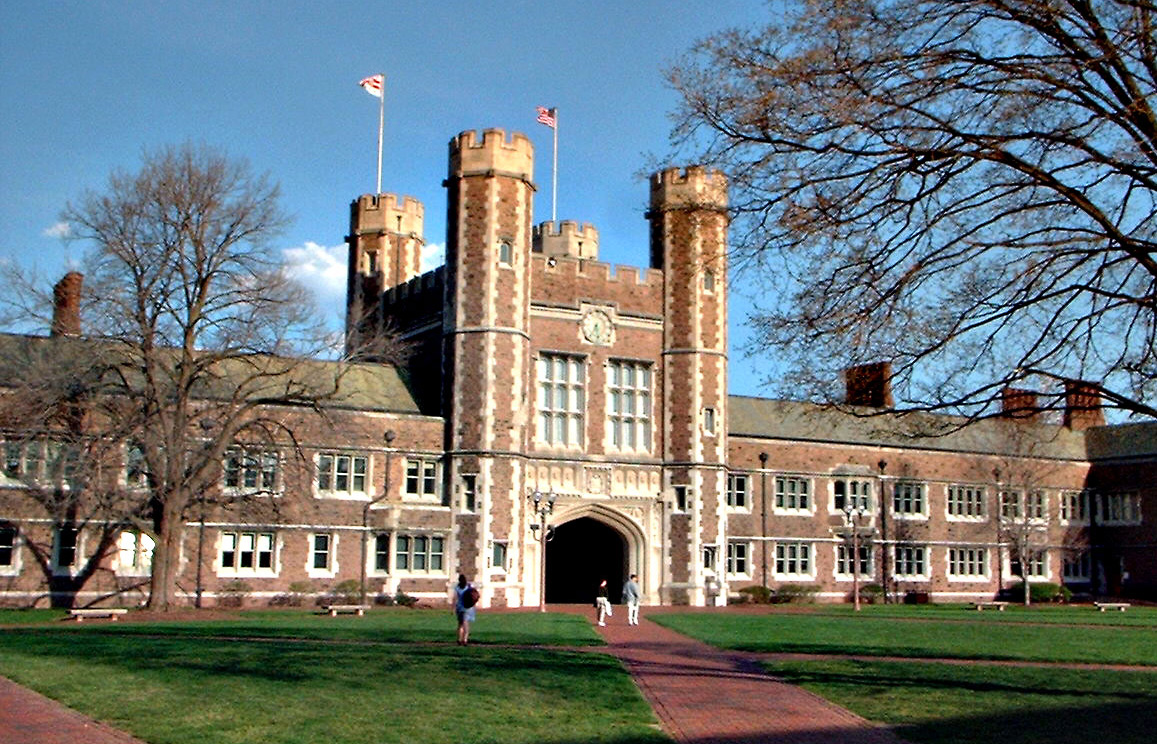

In [3]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

url = 'https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg'

response = requests.get(url)
image = Image.open(BytesIO(response.content))
image.load()

print(np.asarray(image))

image


# Python ile Pixellerden Image Oluşturma

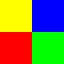

In [10]:
from PIL import Image
import numpy as np

width, height = 64, 64
data = np.zeros((height, width, 3), dtype=np.uint8)

for row in range(32):
    for col in range(32):
        data[row, col] = [255, 255, 0]

for row in range(32):
    for col in range(32):
        data[row +32, col] = [255, 0, 0]

for row in range(32):
    for col in range(32):
        data[row + 32, col + 32] = [0, 255, 0]

for row in range(32):
    for col in range(32):
        data[row, col + 32] = [0, 0, 255]

image = Image.fromarray(data, 'RGB')

image


# Python ile Pixel Seviyesinde Image Transformasyonu

Row = 744, Col=1157


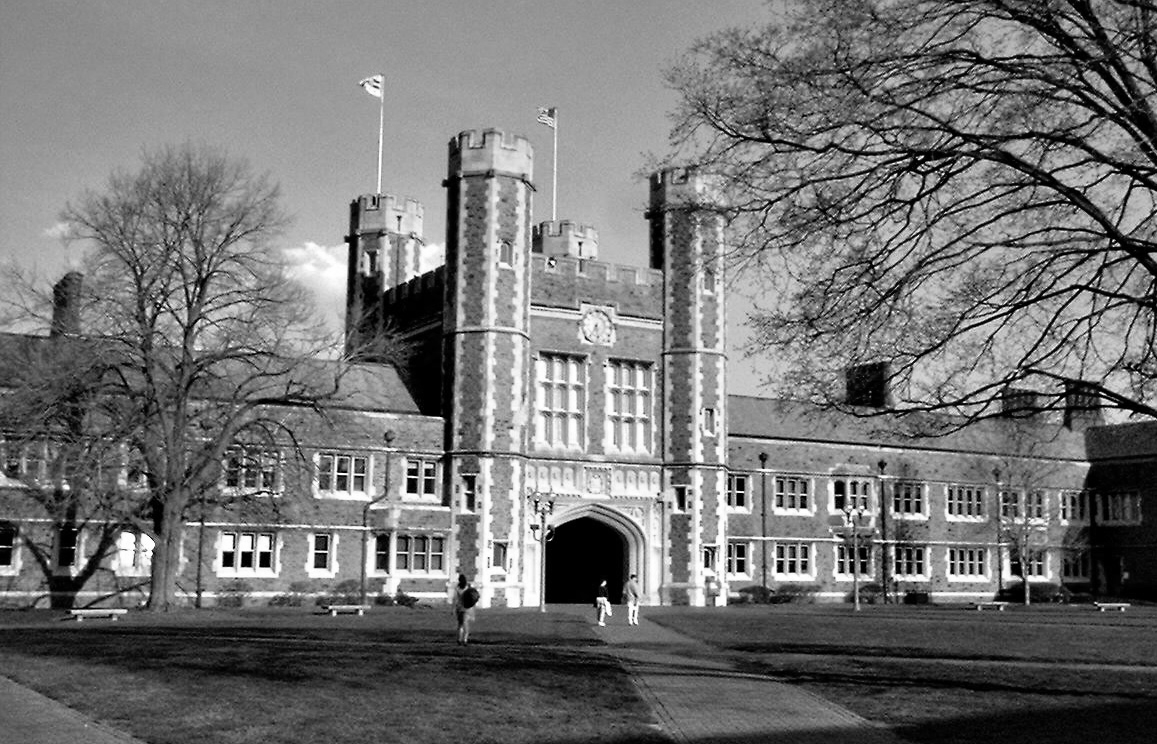

In [11]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO

url = 'https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg'

response = requests.get(url)
image = Image.open(BytesIO(response.content))
image.load()

image_array = np.asarray(image)
row = image_array.shape[0]
col = image_array.shape[1]

print(f'Row = {row}, Col={col}')

image2_array = np.zeros((row, col, 3), dtype=np.uint8)

for r in range(row):
    for c in range(col):
        t = np.mean(image_array[r, c])
        image2_array[r, c] = [t, t, t]

image2 = Image.fromarray(image2_array, 'RGB')
image2

# Image Standardize Etme

Aşağıdaki kod ile, bir dizi görüntüyü okunmakta ve hepsinin aynı boyuta  getrilmekete ve tam olarak kare yapılmaktadır. Girdi görüntüleri kare değilse kare yapılmaktadır.

https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg


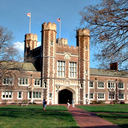

https://upload.wikimedia.org/wikipedia/commons/f/ff/WashU_Graham_Chapel.JPG


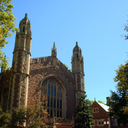

https://upload.wikimedia.org/wikipedia/commons/9/9e/SeigleHall.jpg


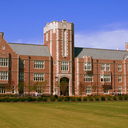

https://upload.wikimedia.org/wikipedia/commons/a/aa/WUSTLKnight.jpg


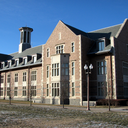

https://upload.wikimedia.org/wikipedia/commons/3/32/WashUABhall.jpg


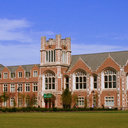

https://upload.wikimedia.org/wikipedia/commons/c/c0/Brown_Hall.jpg


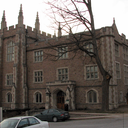

https://upload.wikimedia.org/wikipedia/commons/f/f4/South40.jpg


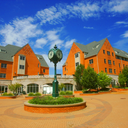

(7, 49152)


In [4]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
from IPython.display import display, HTML
import numpy as np

images = [
    'https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/f/ff/WashU_Graham_Chapel.JPG',
    'https://upload.wikimedia.org/wikipedia/commons/9/9e/SeigleHall.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/a/aa/WUSTLKnight.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/3/32/WashUABhall.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/c/c0/Brown_Hall.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/f/f4/South40.jpg'
]

def make_square(img):
    cols, rows = img.size
    extra = abs(rows - cols) / 2
    
    if rows > cols:
        r = (0, extra, cols, cols + extra)
    else:
        r = (extra, 0, rows + extra, rows)
    
    return img.crop(r)

x=[]

for url in images:
    ImageFile.LOAD_TRUNCATED_IMAGES = False
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.load()
    img = make_square(img)
    img = img.resize((128, 128), Image.ANTIALIAS)
    print(url)
    display(img)
    img_array = np.asarray(img)
    img_array = img_array.flatten()
    img_array = img_array.astype(np.float32)
    img_array = (img_array - 128) / 128
    x.append(img_array)
    
x= np.array(x)
print(x.shape)


# Görüntüye Gürültü Ekleme

Aşağıdaki kod ile, gürültü oluşturmak için görüntüye rastgele siyah kareler eklenmektedir.

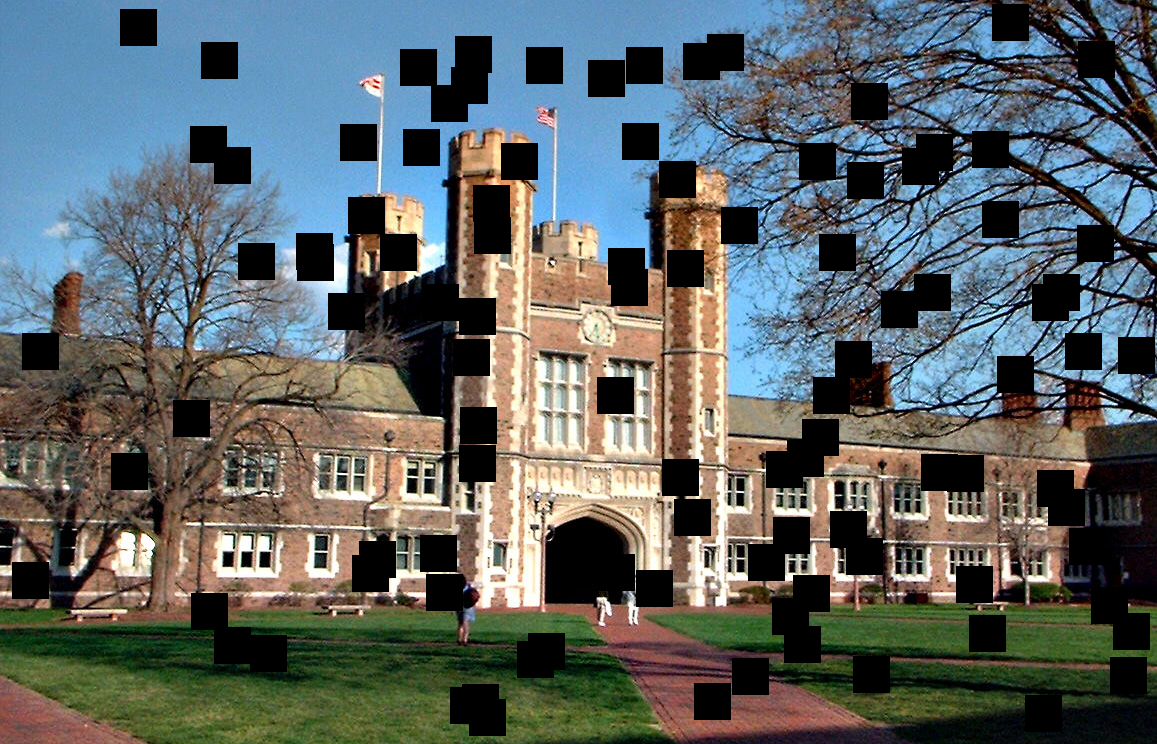

In [5]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np


def add_noise(img):
    img2 = img.copy()
    rows = img2.shape[0]
    cols = img2.shape[1]
    s = int(min(rows, cols) / 20)
    
    for i in range(100):
        x = np.random.randint(cols - s)
        y = np.random.randint(rows - s)
        img2[y:(y+s), x:(x+s)] = 0
    
    return img2

url = 'https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg'
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.load()

img_array = np.array(img)
rows = img_array.shape[0]
cols = img_array.shape[1]

im2_array = img_array.astype(np.uint8)
im2_array = add_noise(im2_array)
im2 = Image.fromarray(im2_array, 'RGB')
im2



# Computer Vision

CNN'leirn önceki sinir ağlarıyla bazı önemli farklılıklar ve benzerlikler vardır.

<li>Genellikle sınıflandırma kullanılır</li>
<li>Sinir ağına giriş artık 3 boyutludur (yükseklik, genişlik, renk)</li>
<li>Veriler dönüştürülmez, z-skorları veya dummy değişkenler yoktur.</li>
<li>İşlem süresi çok daha uzundur.</li>
<li>Farklı katman süreleri vardır: dense layers , convolution layers and max pooling layers.</li>
<li>Veriler artık CSV dosyaları olarak gelmez. TensorFlow, bir sinir ağı için doğrudan görüntüden girişe gitmek için bazı yardımcı fonksiyonlar sağlar. </li>

# Computer Vision Datasets

Computer Vision için birçok veri seti vardır. En popüler iki tanesi MNIST digits  ve CIFAR image dataset'leridir.

## MNIST Digits Dataset

<img src='mnist.png'/>
<center>MNIST Veri Seti(Kaynak : Jeff Heaton, Applications of Deep Neural Networks)</center>

## MNIST Fashion Dataset

Fashion-MNIST, Zalando’nun makale resimlerinden oluşan bir veri kümesidir - 60.000 örnekten oluşan bir eğitim seti ve 10.000 örnekten oluşan bir test setinden oluşur. Her örnek, 10 sınıftan bir etiketle ilişkilendirilmiş 28x28 gri tonlamalı bir görüntüdür.

<img src='mnistfashion.png'/>
<center>MNIST Fashion Veri Seti(Kaynak : Jeff Heaton, Applications of Deep Neural Networks)</center>


## CIFAR Dataset

CIFAR-10 veri seti, 10 sınıfa bölünmüş düşük çözünürlüklü görüntüler içerir. CIFAR-100 veri kümesi bir hiyerarşide 100 sınıf içerir.

<img src='cifar.png'/>
<center>CIFAR Veri Seti(Kaynak : Jeff Heaton, Applications of Deep Neural Networks)</center>

#  Convolutional Neural Networks (CNNs)

Evrişimli sinir ağı (CNN), bilgisayar görme alanını (CV) derinden etkileyen bir sinir ağı teknolojisidir. Fukushima (1980), konvolüsyonel sinir ağının orijinal konseptini tanıttı ve LeCun, Bottou, Bengio & Haffner (1998) bu çalışmayı büyük ölçüde geliştirdi. Bu araştırmadan Yan LeCun, ünlü LeNet-5 sinir ağı mimarisini tanıttı.

<img src='lnet5.png'/>
<center>LeNet-5 Mimarisi(Kaynak : Jeff Heaton, Applications of Deep Neural Networks)</center>

Computer vision esas olarak CNN'leri kullansa da, bu teknolojinin alan dışında da bazı uygulamaları vardır.
Görsel olmayan verilerde CNN kullanılmak istenirse, verilerin görsel verilerin özelliklerini taklit edebilmesi için kodlamanın bir yolunu bulmak gerekmektedir.</br>


Ölçek, döndürme ve gürültü, geçmişte computer vision araştırmaları için zorluklar ortaya koymuştur. Bir örnekle biyolojik gözlerin karmaşıklığını gözlemleyelim. Bir arkadaş, üzerinde çok sayıda yazı olan bir kağıt parçasını kaldırsın. Arkadaşınız size yaklaştıkça, numara hala tanımlayabilirsiniz. Aynı şekilde, arkadaşınız kağıdı çevirdiğinde numarayı yine de tanımlayabilirsiniz. Son olarak, arkadaşınız sayfanın üstüne çizgiler çizerek gürültü yaratır, ancak yine de numarayı tanımlayabilirsiniz. Görebileceğiniz gibi, bu örnekler biyolojik gözün yüksek işlevini gösterir ve CNN'lerin arama buluşunu daha iyi anlamanıza izin verir. Yani, bu sinir ağı, bilgisayarla görme alanında ölçek, döndürme ve gürültüyü işleme yeteneğine sahiptir. </br>

CNN'lerle beraber aşağıdaki layer tipleri kullanılacaktır.

<li><b>Dense Layers:</b> Fully Connected Layers</li>
<li><b>Convolution Layers:</b> Görüntüleri taramak için kullanılır</li>
<li><b>Max Pooling Layers:</b> Görüntüleri altörneklemek için kullanılır</li>
<li><b>Dropout Layers:</b> Regularization eklemek için kullanılır</li>


## Convolution Layers

Hiperparametreleri şunlardır:</br>

<li>Number of filters</li>
<li>Filter Size</li>
<li>Stride</li>
<li>Padding</li>
<li>Activation Function/Non-Linearity</li>

Convolution Layer'ın birincil amacı; kenarlar, çizgiler, renk lekeleri ve diğer görsel öğeler gibi özellikleri algılamaktır. Filtreler bu özellikleri algılayabilir. Bir evrişim tabakasına ne kadar çok filtre verilirse, o kadar fazla özellik tespit edebilir.</br>

Filtre, görüntünün üzerini tarayan kare şekilli bir nesnedir. Bir grid, bir gridin tek tek piksellerini temsil edebilir. Convolution Layer, görüntünün her satırı üzerinde soldan sağa süpüren daha küçük bir grid olarak düşünülebilir. Ayrıca kare şeklindeki filtrenin hem genişliğini hem de yüksekliğini belirten bir hiper parametre vardır. 

Bir Convolution Layer, kendisiyle önceki katman veya görüntü gridi arasında ağırlıklara sahiptir. Her Convolution Layer'daki her piksel bir ağırlıktır. Bu nedenle, bir Convolution Layer ile önceki katmanı veya görüntü alanı arasındaki ağırlıkların sayısı aşağıdaki gibidir:

<div align='center'><b>Filter Size * Filter Size * Number of Filters</b></div>

Örneğin filter Size 5 ise (5 X 5)ve 10 filtre uygulanıyorsa, 250 ağırlık olacaktır.</br>


<img src='convolutional.png'>
<center>Convolutional Neural Network(Kaynak : Jeff Heaton, Applications of Deep Neural Networks)</center>

Yukarıdaki şekil, size'ı 4 ve padding size'ı 1 olan bir kıvrımlı filtreyi göstermektedir. Padding Size, filtrenin süpürdüğü alandaki sıfırların sınırından sorumludur. Resim gerçekte 8x7 olmasına rağmen, ekstra padding, filtrenin süpürmesi için 9x8 sanal bir resim boyutu sağlar. Stride, evrişimli filtrelerin duracağı konumların sayısını belirtir. Evrişimli filtreler, adımda belirtilen hücre sayısı kadar ilerleyerek sağa doğru hareket eder. En sağa ulaşıldığında, evrişimli filtre en sola geri hareket eder, ardından adım miktarı kadar aşağı iner ve tekrar sağa doğru devam eder. </br>

Stride Size ilgili bazı kısıtlamalar vardır. adım 0 olamaz. Adım 0'a ayarlanırsa, evrişimli filtre asla hareket etmez. Ayrıca ne adım ne de evrişimli filtre boyutu önceki ızgaradan daha büyük olamaz. Bir image genişliği (w) için, stride (s), padding (p) ve filtre genişliği (f) üzerinde ek kısıtlamalar vardır. Spesifik olarak, evrişimli filtre en sol veya en üst sınırdan başlayabilmeli, belirli sayıda adım atabilmeli ve en sağ veya en alt sınıra inebilmelidir. Aşağıdaki denklem, bir evrişimli operatörün görüntüyü geçmek için atması gereken adım sayısını gösterir:

<img src='convformula.png'/>
<center>(Kaynak : Jeff Heaton, Applications of Deep Neural Networks)</center>

Step bir tamsayı olmalıdır. Başka bir deyişle, ondalık basamağa sahip olamaz. Padding'in (p) değeri, bu denklemin bir tamsayı değeri haline getirilmesi için ayarlanmalıdır. 

## Max Pooling Layers

Max Pooling Layers, bir 3B kutuyu daha küçük boyutlara sahip yeni bir kutuya dönüştürür. Tipik olarak, her zaman bir Max Pooling Layer, evrişimli katmanın hemen ardından yerleştirilebilir. LENET, C1 ve C3 katmanlarından hemen sonraki maksimum havuz katmanını gösterir. Bu maksimum havuz katmanları, içlerinden geçen 3B kutuların boyutlarını aşamalı olarak azaltır. Bu teknik aşırı uyumu önleyebilir (Krizhevsky, Sutskever & Hinton, 2012).

Bir pooling layer aşağıdaki hiperparametrelere sahip olabilir.

<li>Spatial Extent (f)</li>
<li>Stride (s)</li>

Evrişimli katmanların aksine, maksimum havuz katmanları padding kullanmaz. Ek olarak, maksimum havuz katmanlarının ağırlıkları yoktur, bu nedenle eğitim onları etkilemez. Bu katmanlar, 3B kutu girişlerini basitçe indirger. Bir max-pool katmanının 3D box çıktısının genişliği bu denkleme eşit olacaktır:

<img src='maxpool1.png'/>
<center>(Kaynak : Jeff Heaton, Applications of Deep Neural Networks)</center>

Max-pool katmanı tarafından üretilen 3 boyutlu kutunun yüksekliği, bu denklem ile benzer şekilde hesaplanır:

<img src='maxpool2.png'/>
<center>(Kaynak : Jeff Heaton, Applications of Deep Neural Networks)</center>

Max-pool katmanı tarafından üretilen 3 boyutlu kutunun derinliği, 3 boyutlu kutunun girdi olarak aldığı derinliğe eşittir. Bir maksimum havuz katmanının hiper parametreleri için en yaygın ayar f = 2 ve s = 2'dir. Uzamsal genişlik (f), 2x2'lik kutuların tek piksele küçültüleceğini belirtir. Bu dört pikselden maksimum değere sahip piksel, yeni ızgaradaki 2x2 pikseli temsil edecektir. Boyut 4 kareleri boyut 1 ile değiştirildiği için piksel bilgilerinin % 75'i kaybolur. Aşağıdaki şekil, bu dönüşümü 6x6 boyutundaki bir ızgaranın 3x3'e dönüştüğünü göstermektedir:

<img src='maxpool3.png'/>
<center>Maximum Pooling(Kaynak : Jeff Heaton, Applications of Deep Neural Networks)</center>

Yukarıdaki diyagram her pikseli tek bir sayı olarak göstermektedir. Gri tonlamalı bir görüntü bu özelliğe sahip olacaktır. Bir RGB görüntüsü için, hangi pikselin maksimum değere sahip olduğunu belirlemek için genellikle üç sayının ortalaması alınır.

# MNIST Digit Veriseti'ne Ulaşım

In [1]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(f'X_train boyutu = {X_train.shape}')
print(f'y_train boyutu = {y_train.shape}')
print('---------------------------------------')
print(f'X_test boyutu = {X_test.shape}')
print(f'y_test boyutu = {y_test.shape}')

X_train boyutu = (60000, 28, 28)
y_train boyutu = (60000,)
---------------------------------------
X_test boyutu = (10000, 28, 28)
y_test boyutu = (10000,)


In [23]:
# display digits
from IPython.display import display
import pandas as pd

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 5)

print(f'X_train boyutu = {X_train.shape}')
print(f'Labels = {y_train}')

first_row = X_train[0]

print(f'first_row shape = {first_row.shape}')

pd.DataFrame(first_row)

X_train boyutu = (60000, 28, 28)
Labels = [5 0 4 ... 5 6 8]
first_row shape = (28, 28)


0   1   2   3   4   5   6   ...  21  22  23  24  25  26  27
0    0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0
1    0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0
..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..
26   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0
27   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0

[28 rows x 28 columns]

Label =  1


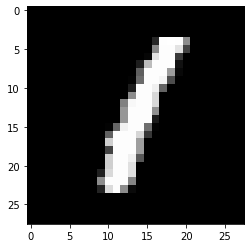

In [2]:
# display as image

import matplotlib.pyplot as plt
import numpy as np

digit = 105

a = X_train[digit]
plt.imshow(a, cmap='gray', interpolation='nearest')
print('Label = ', y_train[digit])


<Figure size 432x288 with 0 Axes>

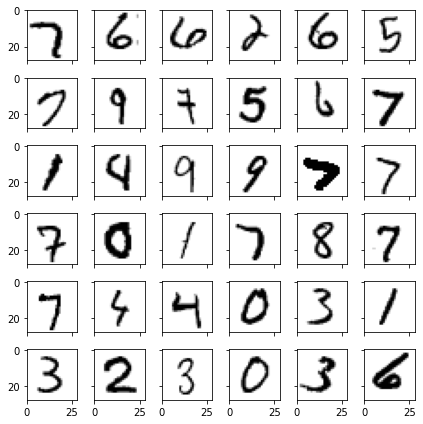

In [3]:
# random image representation

import random

ROWS = 6

random_indices = random.sample(range(X_train.shape[0]), ROWS*ROWS)

sample_images = X_train[random_indices, :]

plt.clf()

fig, axes = plt.subplots(ROWS, ROWS, figsize=(ROWS, ROWS), sharex=True, sharey=True)

for i in range(ROWS*ROWS):
    subplot_row = i // ROWS
    subplot_col = i % ROWS
    ax = axes[subplot_row, subplot_col]
    
    plt_image = np.reshape(sample_images[i,:], (28, 28))
    ax.imshow(plt_image, cmap='gray_r')
    
    ax.set_xbound([0, 28])
    
plt.tight_layout()
plt.show()

In [4]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
import time

batch_size = 128
num_classes = 10
epochs = 12

img_rows, img_cols = 28, 28
# https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/
if backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

print(f'X_train shape = {X_train.shape}')
print(f'Trainin sample size = {X_train.shape[0]}')
print(f'Test sample size = {X_test.shape[0]}')

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train shape = (60000, 28, 28, 1)
Trainin sample size = 60000
Test sample size = 10000


In [5]:
start_time = time.time()
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
          verbose=2, validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss = {score[0]}')
print(f'Test Accuracy = {score[1]}')

elapsed_time = time.time() - start_time
print(f' Elapsed Time = {time_string(elapsed_time)}')


Epoch 1/12


KeyboardInterrupt: 

In [37]:
from sklearn.metrics import accuracy_score
small_x = X_test[1:100]
small_y = y_test[1:100]
small_y2 = np.argmax(small_y, axis=1)
predicted = model.predict(small_x)
predicted = np.argmax(predicted, axis=1)
score = accuracy_score(small_y2, predicted)
score

0.98989898989899

# MNIST Fashion Dataset Example

In [1]:
from tensorflow.keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print(f'X_train boyutu = {X_train.shape}')
print(f'y_train boyutu = {y_train.shape}')
print('---------------------------------------')
print(f'X_test boyutu = {X_test.shape}')
print(f'y_test boyutu = {y_test.shape}')

4423680/4422102 [==============================] - 2s 0us/step
X_train boyutu = (60000, 28, 28)
y_train boyutu = (60000,)
---------------------------------------
X_test boyutu = (10000, 28, 28)
y_test boyutu = (10000,)


In [5]:
# display digits
from IPython.display import display
import pandas as pd

pd.set_option('display.max_columns', 7)
pd.set_option('display.max_rows', 10)

print(f'X_train boyutu = {X_train.shape}')
print(f'Labels = {y_train}')

first_row = X_train[0]

print(f'first_row shape = {first_row.shape}')

pd.DataFrame(first_row)

X_train boyutu = (60000, 28, 28)
Labels = [9 0 0 ... 3 0 5]
first_row shape = (28, 28)


0   1   2   ...   25   26  27
0    0   0   0  ...    0    0   0
1    0   0   0  ...    0    0   0
2    0   0   0  ...    0    0   0
3    0   0   0  ...    1    1   0
4    0   0   0  ...    0    0   3
..  ..  ..  ..  ...  ...  ...  ..
23   0   0  74  ...  216  170   0
24   2   0   0  ...   58    0   0
25   0   0   0  ...    0    0   0
26   0   0   0  ...    0    0   0
27   0   0   0  ...    0    0   0

[28 rows x 28 columns]

Label =  9


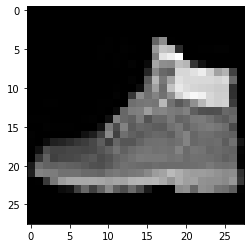

In [6]:
# display as image

import matplotlib.pyplot as plt
import numpy as np

digit = 90

a = X_train[digit]
plt.imshow(a, cmap='gray', interpolation='nearest')
print('Label = ', y_train[digit])


<Figure size 432x288 with 0 Axes>

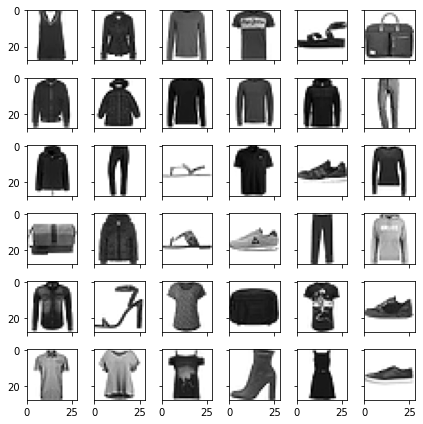

In [7]:
# random image representation

import random

ROWS = 6

random_indices = random.sample(range(X_train.shape[0]), ROWS*ROWS)

sample_images = X_train[random_indices, :]

plt.clf()

fig, axes = plt.subplots(ROWS, ROWS, figsize=(ROWS, ROWS), sharex=True, sharey=True)

for i in range(ROWS*ROWS):
    subplot_row = i // ROWS
    subplot_col = i % ROWS
    ax = axes[subplot_row, subplot_col]
    
    plt_image = np.reshape(sample_images[i,:], (28, 28))
    ax.imshow(plt_image, cmap='gray_r')
    
    ax.set_xbound([0, 28])
    
plt.tight_layout()
plt.show()

In [8]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
import time

batch_size = 128
num_classes = 10
epochs = 12

img_rows, img_cols = 28, 28
# https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/
if backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

print(f'X_train shape = {X_train.shape}')
print(f'Trainin sample size = {X_train.shape[0]}')
print(f'Test sample size = {X_test.shape[0]}')

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train shape = (60000, 28, 28, 1)
Trainin sample size = 60000
Test sample size = 10000


In [10]:
start_time = time.time()
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
          verbose=2, validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss = {score[0]}')
print(f'Test Accuracy = {score[1]}')

elapsed_time = time.time() - start_time
print(f' Elapsed Time = {time_string(elapsed_time)}')

Epoch 1/12
469/469 - 75s - loss: 0.5549 - accuracy: 0.8021 - val_loss: 0.3599 - val_accuracy: 0.8680
Epoch 2/12
469/469 - 71s - loss: 0.3757 - accuracy: 0.8660 - val_loss: 0.3069 - val_accuracy: 0.8888
Epoch 3/12
469/469 - 70s - loss: 0.3246 - accuracy: 0.8822 - val_loss: 0.2775 - val_accuracy: 0.8985
Epoch 4/12
469/469 - 70s - loss: 0.2964 - accuracy: 0.8917 - val_loss: 0.2637 - val_accuracy: 0.9075
Epoch 5/12
469/469 - 68s - loss: 0.2723 - accuracy: 0.9009 - val_loss: 0.2483 - val_accuracy: 0.9111
Epoch 6/12
469/469 - 69s - loss: 0.2512 - accuracy: 0.9080 - val_loss: 0.2559 - val_accuracy: 0.9056
Epoch 7/12
469/469 - 68s - loss: 0.2336 - accuracy: 0.9146 - val_loss: 0.2296 - val_accuracy: 0.9151
Epoch 8/12
469/469 - 70s - loss: 0.2221 - accuracy: 0.9180 - val_loss: 0.2300 - val_accuracy: 0.9185
Epoch 9/12
469/469 - 70s - loss: 0.2054 - accuracy: 0.9235 - val_loss: 0.2206 - val_accuracy: 0.9213
Epoch 10/12
469/469 - 68s - loss: 0.1956 - accuracy: 0.9268 - val_loss: 0.2280 - val_accura